In [1]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import seaborn as sns

In [4]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [ ]:
## Initial Broad Sweep of the Parameter Space
param_grid = {'max_depth': [4, 6, 8],
                'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                'reg_lambda':[0, 10, 100],
                'n_estimators':[1000, 2000, 3000, 4000],
                'gamma': [0, 5, 10],
                'subsample': [0.3, 0.5, 1.0],
                "colsample_bytree": [0.5, 0.75, 1.0]}

xgboost = RandomizedSearchCV(estimator = XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,                             
                             verbose = 1,
                             n_jobs = -1,
                             n_iter = 20,
                             cv = 5).fit(X_train, y_train)

xgboost.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'subsample': 1.0,
 'reg_lambda': 0,
 'n_estimators': 2000,
 'max_depth': 8,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [ ]:
# No rounding
mean_squared_error(y_test, xgboost.predict(X_test))

0.41436566289534504

<Axes: ylabel='quality'>

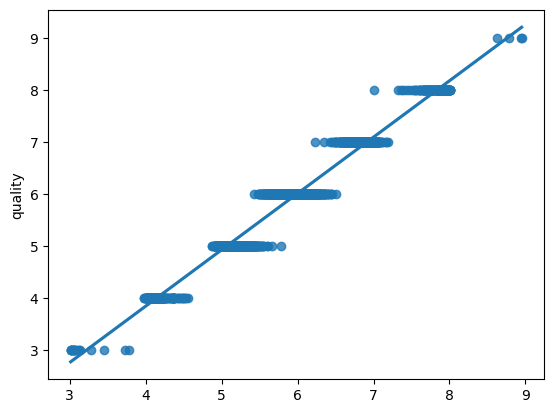

In [ ]:
sns.regplot(x = xgboost.predict(X_train), y = y_train)

<Axes: ylabel='quality'>

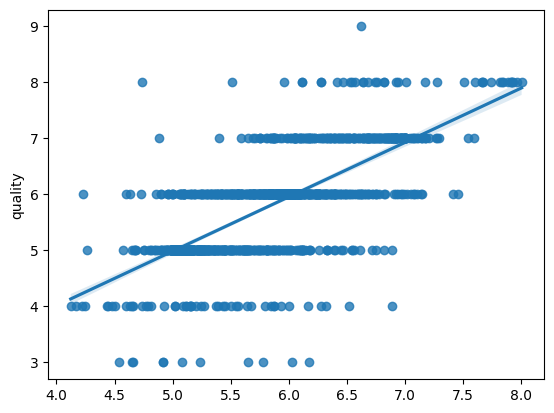

In [ ]:
sns.regplot(x = xgboost.predict(X_test), y = y_test)

In [ ]:
pred_series = pd.Series(xgboost.predict(X_test))
pred_series_rounded = pred_series.round()

In [ ]:
mean_squared_error(y_test, pred_series_rounded)

0.4623076923076923

In [ ]:
# Visualizing the parameter space to understand how to narrow subsequent searches
cv_results = pd.DataFrame(xgboost.cv_results_)

Text(0, 0.5, 'K-fold RMSE')

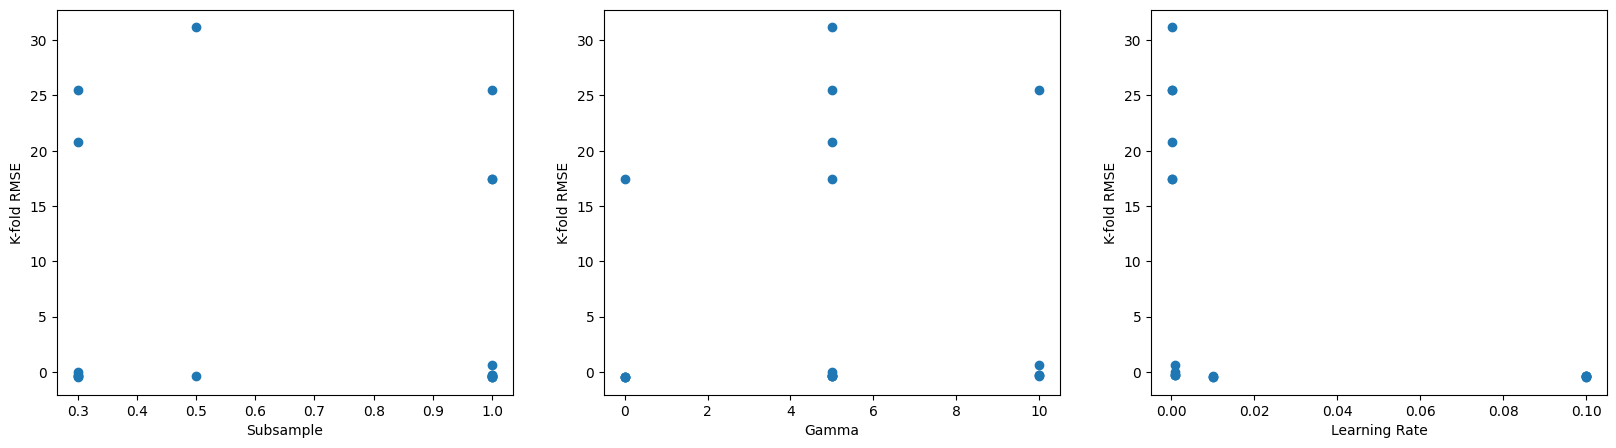

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20,5))
plt.subplots_adjust(wspace = 0.2)
axes[0].plot(cv_results.param_subsample, -cv_results.mean_test_score, 'o')
axes[0].set_xlabel('Subsample')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_gamma, -cv_results.mean_test_score, 'o')
axes[1].set_xlabel('Gamma')
axes[1].set_ylabel('K-fold RMSE')
axes[2].plot(cv_results.param_learning_rate, -cv_results.mean_test_score, 'o')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('K-fold RMSE')

Text(0, 0.5, 'K-fold RMSE')

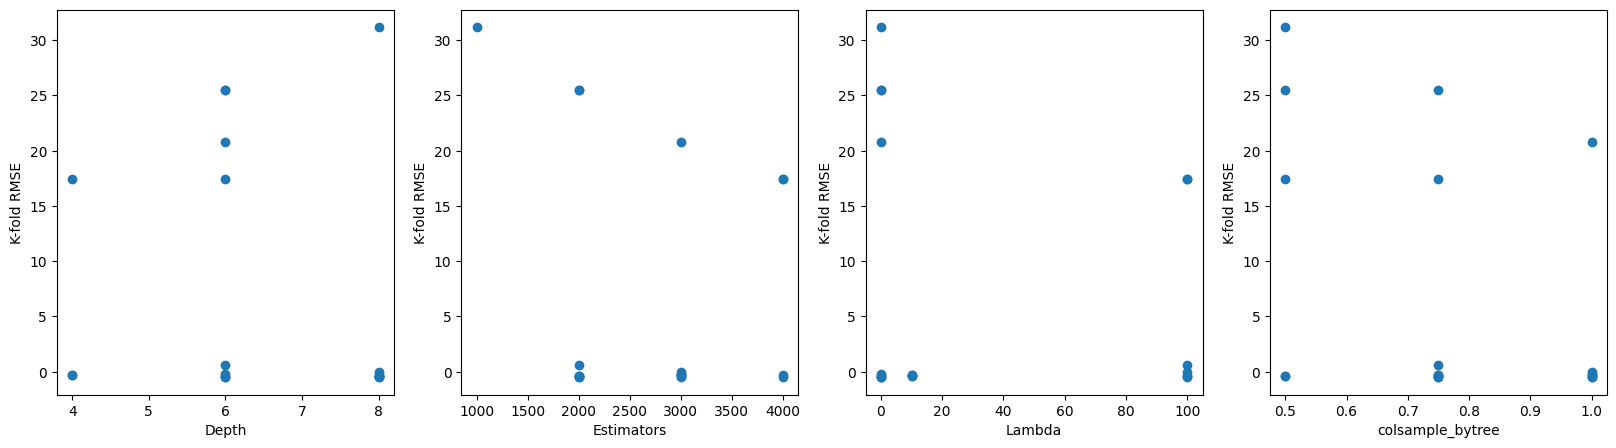

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (20,5))
plt.subplots_adjust(wspace = 0.2)
axes[0].plot(cv_results.param_max_depth, -cv_results.mean_test_score, 'o')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_n_estimators, -cv_results.mean_test_score, 'o')
axes[1].set_xlabel('Estimators')
axes[1].set_ylabel('K-fold RMSE')
axes[2].plot(cv_results.param_reg_lambda, -cv_results.mean_test_score, 'o')
axes[2].set_xlabel('Lambda')
axes[2].set_ylabel('K-fold RMSE')
axes[3].plot(cv_results.param_colsample_bytree, -cv_results.mean_test_score, 'o')
axes[3].set_xlabel('colsample_bytree')
axes[3].set_ylabel('K-fold RMSE')

In [5]:
# Finer grid search

# {'subsample': 1.0,
#  'reg_lambda': 0,
#  'n_estimators': 2000,
#  'max_depth': 8,
#  'learning_rate': 0.01,
#  'gamma': 0,
#  'colsample_bytree': 1.0}

param_grid = {'max_depth': [4, 5, 6, 7, 8],
                'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.05],
                'reg_lambda':[0, 10, 20, 30, 40, 70, 100],
                'n_estimators':[3000, 4000, 5000],
                'gamma': [0, 3, 5, 7, 10],
                'subsample': [0.5, 1.0],
                "colsample_bytree": [0.6, 0.75, 0.8, 0.9]}

xgboost2 = RandomizedSearchCV(estimator = XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid,                             
                             verbose = 1,
                             n_jobs = -1,
                             n_iter = 50,
                             cv = 5).fit(X_train, y_train)

xgboost2.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'subsample': 0.5,
 'reg_lambda': 10,
 'n_estimators': 4000,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [7]:
optimized_xgboost = XGBRegressor(n_estimators = 4000, learning_rate = 0.01, subsample = 0.5, reg_lambda = 10, max_depth = 7, gamma = 0, colsample_bytree = 0.6, random_state = 1)
optimized_xgboost.fit(X_train, y_train)

pred_series = pd.Series(optimized_xgboost.predict(X_test))
pred_series_rounded = pred_series.round()

mean_squared_error(y_test, pred_series_rounded)

0.45692307692307693

In [6]:
cv_results = pd.DataFrame(xgboost2.cv_results_)

Text(0, 0.5, 'K-fold RMSE')

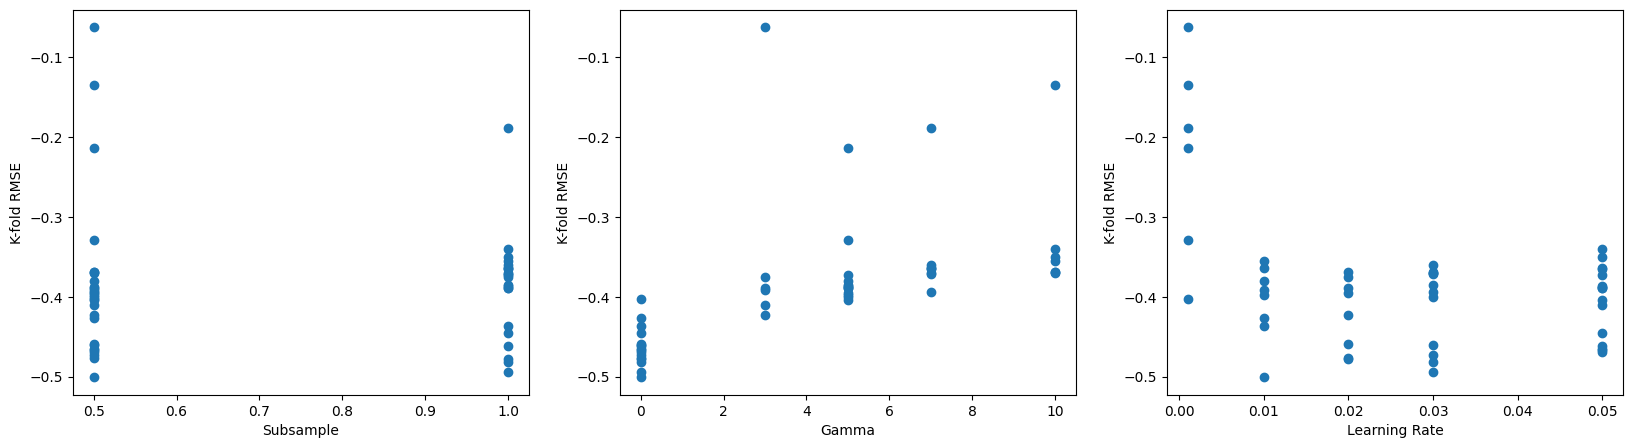

In [7]:

fig, axes = plt.subplots(1, 3, figsize = (20,5))
plt.subplots_adjust(wspace = 0.2)
axes[0].plot(cv_results.param_subsample, -cv_results.mean_test_score, 'o')
axes[0].set_xlabel('Subsample')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_gamma, -cv_results.mean_test_score, 'o')
axes[1].set_xlabel('Gamma')
axes[1].set_ylabel('K-fold RMSE')
axes[2].plot(cv_results.param_learning_rate, -cv_results.mean_test_score, 'o')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('K-fold RMSE')

Text(0, 0.5, 'K-fold RMSE')

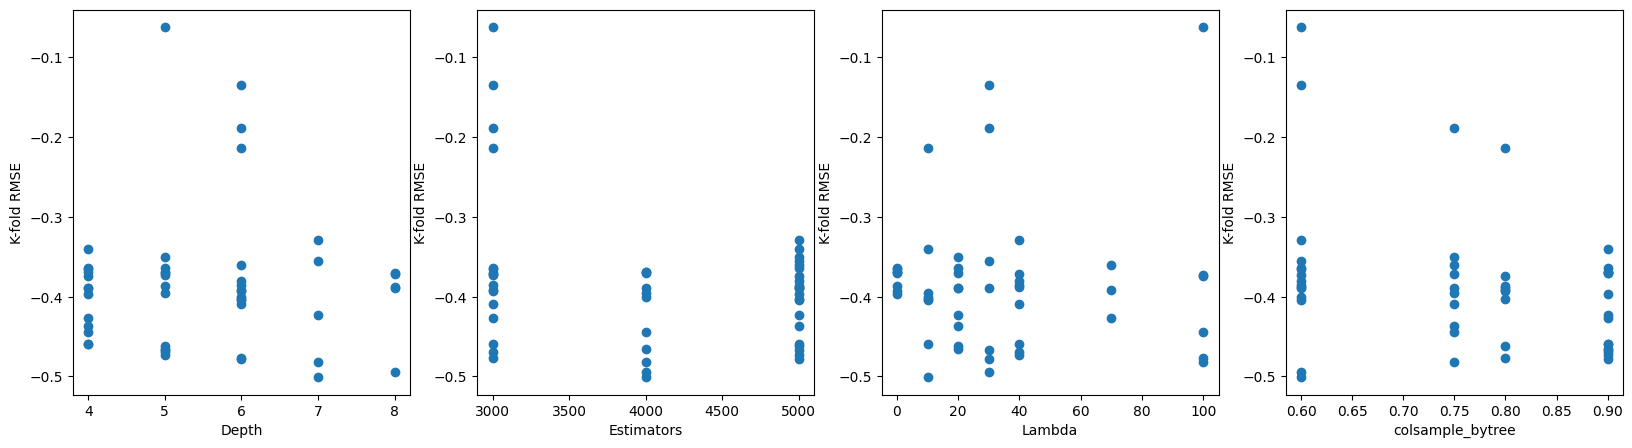

In [8]:
fig, axes = plt.subplots(1, 4, figsize = (20,5))
plt.subplots_adjust(wspace = 0.2)
axes[0].plot(cv_results.param_max_depth, -cv_results.mean_test_score, 'o')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_n_estimators, -cv_results.mean_test_score, 'o')
axes[1].set_xlabel('Estimators')
axes[1].set_ylabel('K-fold RMSE')
axes[2].plot(cv_results.param_reg_lambda, -cv_results.mean_test_score, 'o')
axes[2].set_xlabel('Lambda')
axes[2].set_ylabel('K-fold RMSE')
axes[3].plot(cv_results.param_colsample_bytree, -cv_results.mean_test_score, 'o')
axes[3].set_xlabel('colsample_bytree')
axes[3].set_ylabel('K-fold RMSE')

In [18]:
# {'subsample': 0.5,
#  'reg_lambda': 10,
#  'n_estimators': 4000,
#  'max_depth': 7,
#  'learning_rate': 0.01,
#  'gamma': 0,
#  'colsample_bytree': 0.6}

optimized_xgboost2 = XGBRegressor(n_estimators = 4050, learning_rate = 0.01, subsample = 0.5, reg_lambda = 10, max_depth = 7, gamma = 0, colsample_bytree = 0.6, random_state = 1)
optimized_xgboost2.fit(X_train, y_train)

pred_series = pd.Series(optimized_xgboost2.predict(X_test))
pred_series_rounded = pred_series.round()
mean_squared_error(y_test, pred_series_rounded)

# 0.45615384615384613 4050 estimators

0.45615384615384613

In [ ]:
# Attempting Bayes Optimization

In [ ]:
# Bayesian Optimization of XGBoost Hyperparameters
## To see if Bayesian Optimization will do better than Random Grid Search CV

pbounds = {
    'learning_rate': (0.001, 1.0),
    'n_estimators': (100, 4000),
    'max_depth': (3,10),
    'subsample': (0.3, 1.0),  # Change for big datasets
    'gamma': (0, 10),
    'reg_lambda': (0, 100)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        gamma,
                        reg_lambda):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBRegressor(
        max_depth = max_depth,
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        gamma = gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv = 5, scoring='neg_mean_squared_error'))

optimizer = BayesianOptimization(
    f = xgboost_hyper_param,
    pbounds = pbounds,
    random_state = 1,
)


In [ ]:
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.4946   | 4.17      | 0.7206    | 3.001     | 1.279e+03 | 14.68     | 0.3646    |
| 2         | -0.4596   | 1.863     | 0.3462    | 5.777     | 2.201e+03 | 41.92     | 0.7797    |
| 3         | -0.5      | 2.045     | 0.8782    | 3.192     | 2.715e+03 | 41.73     | 0.6911    |
| 4         | -0.4281   | 1.404     | 0.1989    | 8.605     | 3.876e+03 | 31.34     | 0.7846    |
| 5         | -0.5065   | 8.764     | 0.8947    | 3.595     | 252.3     | 16.98     | 0.9147    |
| 6         | -0.4752   | 2.345     | 0.612     | 7.848     | 2.205e+03 | 39.36     | 0.4908    |
| 7         | -0.4948   | 8.112     | 0.3396    | 3.849     | 3.871e+03 | 34.52     | 0.3128    |
| 8         | -0.4736   | 1.397     | 0.5419    | 4.452     | 3.876e+03 | 33.97     | 0.6158    |
| 9         | -0.468

In [ ]:
optimizer.maximize(init_points = 5, n_iter = 15)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -0.489    | 0.7085    | 7.203     | 0.01011   | 5.116     | 525.6     | 9.234     | 18.63     | 0.5419    |
| 2         | -0.4733   | 0.6984    | 5.388     | 0.425     | 7.797     | 692.9     | 87.81     | 2.739     | 0.7693    |
| 3         | -0.4786   | 0.7087    | 5.587     | 0.149     | 4.387     | 2.422e+03 | 96.83     | 31.34     | 0.7846    |
| 4         | -0.4986   | 0.9382    | 8.946     | 0.09419   | 3.273     | 592.5     | 87.81     | 9.835     | 0.5948    |
| 5         | -0.4879   | 0.9789    | 5.332     | 0.695     | 5.209     | 2.091e+03 | 83.46     | 1.829     | 0.8251    |
| 6         | -0.4875   | 0.5164    | 5.37      | 0.534     | 3.137     | 2.427e+03 | 92.6      | 25.5      | 0.7701    |
| 7         | -0.4458   

In [ ]:
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.4945   | 0.7085    | 7.203     | 0.01011   | 5.116     | 525.6     | 0.3646    |
| 2         | -0.4759   | 0.5931    | 3.456     | 0.4028    | 6.772     | 1.316e+03 | 0.7797    |
| 3         | -0.4964   | 0.6022    | 8.781     | 0.03711   | 7.693     | 1.31e+03  | 0.6911    |
| 4         | -0.5484   | 0.5702    | 1.981     | 0.8027    | 9.778     | 1.009e+03 | 0.7846    |
| 5         | -0.5041   | 0.9382    | 8.946     | 0.09419   | 3.273     | 592.5     | 0.9147    |
| 6         | -0.4669   | 0.9264    | 4.005     | 0.1051    | 6.815     | 1.315e+03 | 0.4879    |
| 7         | -0.499    | 0.8711    | 5.935     | 0.5099    | 3.894     | 1.314e+03 | 0.3997    |
| 8         | -0.4822   | 0.8882    | 6.403     | 0.4975    | 8.614     | 1.316e+03 | 0.6406    |
| 9         | -0.523

In [ ]:
# xgb_model_bayesOpt = XGBRegressor(colsample_bytree = 0.7081851804069756,
#                                   subsample = 0.4034757147814606,
#                                   reg_alpha = 70.92006259569803,
#                                   reg_lambda = 5.93423843530807,
#                                   n_estimators = 984,
#                                   max_depth = 6, 
#                                   learning_rate = 0.09626525300856696, 
#                                   gamma = 1).fit(X_train, y_train)


# Implementing the last Bayes Optimizer model
xgb_model_bayesOpt = XGBRegressor(colsample = 0.926371203066647,
                                  subsample = 0.4879450393211324,
                                  # reg_alpha = 70.92006259569803,
                                  # reg_lambda = 5.93423843530807,
                                  n_estimators = 1315,
                                  max_depth = 7, 
                                  learning_rate = 0.105068050089807, 
                                  gamma = 4.004543074048512).fit(X_train, y_train)


[03:59:41] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample" } are not used.



In [ ]:
pred_series = pd.Series(xgb_model_bayesOpt.predict(X_test))
pred_series_rounded = pred_series.round()

In [ ]:
mean_squared_error(y_test, pred_series_rounded)

0.5461538461538461